INSURICARE

PROBLEMA:

- UMA EMPRESA DE SEGUROS TEM OS DADOS DOS CLIENTES QUE COMPRARAM SEGUROS DE SAÚDE, PAGANDO UM VALOR ANUAL.
- O TIME DE PRODUTOS QUER VENDER SEGUROS DE CARRO, MAS QUEREM SABER SE É VIÁVEL.
- O TIME FEZ PERGUNTOU PARA ESSAS PESSOAS SE COMPRARIAM OU NÃO UM SEGURO DE AUTOMÓVEL
- HÁ NOVOS CLIENTES (QUE NÃO PARTICIPARAM DA PESQUISA) NOS QUAIS A EMPRESA TEM INTERESSE EM VENDER O SEGURO DE AUTOMÓVEL.
- ENTRETANTO, HÁ UM LIMITE DE 2000 LIGAÇÕES QUE A EMPRESA PODE FAZER (DE UM TOTAL DE 127 MIL PESSOAS QUE PODERIAM RECEBER AS LIGAÇÕES).
- ASSIM, O TIME DE PRODUTO VAI PASSAR UMA LISTA PARA O TIME DE VENDAS COM OS CLIENTES MAIS PROPENSOS A COMPRAREM O NOVO SEGURO, ORDENADOS.
- **PARA ISSO, SERÁ TREINADO UM CLASSIFICADOR, INDICANDO POR ORDEM, AQUELES NOVOS CLIENTE MAIS PROPENSOS A COMPRAREM O NOVO SEGURO.**

FAZER TODA UMA HISTORIA:
- PROBLEMA DE LEARNING TO RANK
- A EMPRESA JA USA UM MODELO DE MEDIA, BLA BLA  BLA
- QUANTOS CLIENTES QUE QUEREM O SEGURO SE CONSEGUE COM 20,000 LIGACÕES?
- E COM 40,000
- ETC ETC
  


## 1. **Imports**

#### 1.1. **Libraries**

In [78]:
import pandas as pd
import numpy as np
import sqlalchemy as sql
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from dython.nominal import cramers_v
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from category_encoders import OrdinalEncoder, TargetEncoder

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from boruta import BorutaPy
from lightgbm                import LGBMClassifier
from xgboost                 import XGBClassifier
from catboost                import CatBoostClassifier
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve
import optuna


pd.set_option('display.float_format', lambda x: '%.5f' % x)

c:\Users\bruno\OneDrive\Documentos\repos\pa-health-insurance-cross-sell\.venv-hics\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 1.2. **Helper Functions**

In [141]:
def get_data_sql(username, pwd, host, port, database, query_table_users):
    credentials = f'postgresql://{username}:{pwd}@{host}:{port}/{database}' # passing the credentials
    db = sql.create_engine(credentials)
    conn = db.connect() # open connection
    df_raw = pd.read_sql(query_table_users, conn) # get data
    df_raw = df_raw.iloc[:, ~df_raw.columns.duplicated()] # drop duplicated id columns (col_index 5 and 9)
    df_raw = df_raw.drop_duplicates(subset=['id'], keep='first') # drop duplicated id rows
    conn.close() # close connection
    db.dispose()
    return df_raw

def data_shape(df):
    '''
    Gets the number of rows and columns for a given DataFrame.

    Parameters
    ----------
    df : dataframe on which the function will be applied.
    
    Returns
    -------
    None 
    '''   
    print(f'Number of Rows: {df.shape[0]}')
    print(f'Number of Columns: {df.shape[1]}')
    return None  

def to_int_64(df,change_types_list):
    '''
    Changes data type to int64.

    Parameters
    ----------
    df : dataframe on which the function will be applied.
    change_types_list : list of columns on which the function will be applied.

    Returns
    -------
    df : dataframe with new column types.
    '''  
    for i in change_types_list:
        df[f'{i}'] = df[f'{i}'].astype('int64')
    return df   

def descriptive_statistics(df, num_attributes):
    '''
    Creates a descriptive statistics table.

    Parameters
    ----------
    df : dataframe on which the function will be applied.
    num_attributes: dataframes's numerical attributes.    
    
    Returns
    -------
    metrics : descriptive statistics table.
    '''
    # Central Tendency 
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
    
    # Dispersion 
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    
    # Concat
    metrics = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    metrics.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
    return metrics


def cramers_matrix(cat):   
    '''
    Calculates the Cramér's V correlation matrix.

    Parameters
    ----------
    cat: categorical attributes from the data.
        
    Returns
    -------
    None 
    '''
    a1 = cramers_v(cat[cat.columns[0]], cat[cat.columns[0]])
    a2 = cramers_v(cat[cat.columns[0]], cat[cat.columns[1]])
    a3 = cramers_v(cat[cat.columns[1]], cat[cat.columns[0]])
    a4 = cramers_v(cat[cat.columns[1]], cat[cat.columns[1]])

    matrix = pd.DataFrame({'gender':      [a1, a2],
                           'vehicle_age': [a3, a4] })

    matrix = matrix.set_index(matrix.columns)
    
    plt.figure(figsize=(20,12))
    sns.heatmap(matrix, annot=True)
    plt.show()    
    return None     

def feature_importances(model, X_train_n, y_train_n):
    '''
    Ranks the feature importances by using ensemble algorithms.

    Parameters
    ----------
    model : ensemble model used (e.g. Random Forest, Decision Tree, ExtraTrees, etc)
    X_train_n : X train
    y_train_n: y train

    Returns
    -------
    None 
    '''
    # Fitting the model
    model.fit(X_train_n, y_train_n)
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Print feature ranking
    print("Feature Ranking:\n")
    df = pd.DataFrame()
    for i, j in zip(X_train_n, model.feature_importances_):
        aux = pd.DataFrame({'feature': i , 'importance': j}, index=[0])
        df = pd.concat([df, aux], axis=0)

    print(df.sort_values('importance', ascending=False))

    # Plot the ranked features by importance
    plt.title('Feature Importances')
    plt.bar(range(X_train_n.shape[1]), importances[indices], color="b", align="center")
    plt.xticks(range(X_train_n.shape[1]), indices)
    plt.xlim([-1, X_train_n.shape[1]])
    plt.show()
    return None

def precision_at_k(data, k=20000):
    data = data.reset_index(drop=True)
    data['ranking'] = data.index + 1
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

def recall_at_k(data, k=20000):
    data = data.reset_index(drop=True)
    data['ranking'] = data.index + 1
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k'] 
                          
def cross_validation(model, X_train, y_train, k, verbose=True):
    # Number of k folds
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    
    # Empty list to store all metrics
    precision_k_list = [] 
    recall_k_list = []  
    i = 1
    
    for train_cv, val_cv in kfold.split(X_train, y_train):
        if verbose == True:    
            print(f'Fold Number {i}/{k}') 
        else:
            pass

        # Training dataset
        X_train_fold = X_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]

        # Validation dataset
        x_val_fold = X_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]
        
        # Model
        model.fit(X_train_fold, y_train_fold)

        # Prediction
        yhat_proba = model.predict_proba(x_val_fold)

        # Storing the performance of each kfold iteration
        data = pd.DataFrame()        
        data = x_val_fold.copy()
        data['response'] = y_val_fold.copy()
        data['score'] = yhat_proba[:,1].tolist()
        
        data = data.sort_values('score',ascending=False)
        
        # Precision at K
        precision_k = precision_at_k(data)
        precision_k_list.append(precision_k)
        
        # Recall at K
        recall_k = recall_at_k(data)
        recall_k_list.append(recall_k)
        i = i + 1

    return pd.DataFrame({'Model': type(model).__name__,
                         'Precision at K': np.round(np.mean(precision_k_list),4).astype(str) + ' +/- ' + np.round(np.std(precision_k_list),4).astype(str),
                         'Recall at K': np.round(np.mean(recall_k_list),4).astype(str) + ' +/- ' + np.round(np.std(recall_k_list),4).astype(str)}, index=[0])  


def model_eval(model, X_train_ml, y_train_ml, X_val, y_validation, k=20000):    
    '''
    Final Model evaluation, with cumulative gain and lift curves.
    '''

    # Fitting the model
    model.fit(X_train_ml, y_train_ml)
    yhat = model.predict_proba(X_val)

    # Sorting    
    data = X_val.copy()
    data['response'] = y_validation.copy()
    data['score'] = yhat[:,1].tolist()
    data = data.sort_values('score',ascending=False)

    # Precision at K
    precision_k = precision_at_k(data, k=k)
    
    # Recall at K
    recall_k = recall_at_k(data, k=k)
    
    # Plotting both curves
    plot_cumulative_gain(y_validation, yhat);
    plot_lift_curve(y_validation, yhat);

    return pd.DataFrame({'Model': type(model).__name__,
                         'Precision at K': precision_k,
                         'Recall at K': recall_k}, index=[0])                              

#### 1.3. **Collecting Data**

In [3]:
# Credentials (ESCONDER ELAS DEPOIS)
username = 'member'
pwd = 'cdspa'
host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
port = 5432
database = 'comunidadedsdb'

query_table_users = """
    SELECT *
    FROM pa004.users u LEFT JOIN pa004.vehicle   v on (u.id = v.id)
                       LEFT JOIN pa004.insurance i on (u.id = i.id)
"""

df_raw = get_data_sql(username, pwd, host, port, database, query_table_users)

## 2. **Data Descriptions**

In [4]:
df2 = df_raw.copy()

| **Feature**          | **Definition** |
|----------------------|----------------|
| id                   | Unique ID for the customer               |
| gender               |   	Gender of the customer             |
| age                  |        	Age of the customer        |
| region_code          |   Unique code for the region of the customer             |
| policy_sales_channel |   Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc             |
| driving_licence      |     0 : Customer does not have DL, 1 : Customer already has DL           |
| vehicle_age          |   	Age of the Vehicle             |
| vehicle_damage       |   Yes : Customer got his/her vehicle damaged in the past. No : Customer didn't get his/her vehicle damaged in the past.             |
| previously_insured   |1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance                |
| annual_premium       | The amount customer needs to pay as premium in the year              |
| vintage              |   Number of Days, Customer has been associated with the company             |
| response             | 1 : Customer is interested, 0 : Customer is not interested; **This is the target variable**             |

#### 2.1. **Data Dimensions**

In [5]:
data_shape(df2)

Number of Rows: 381109
Number of Columns: 12


#### 2.2. **Data Types**

In [6]:
df2.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

The following columns will have to go through encoding:
- region_code
- policy_sales_channel
- gender
- vehicle_age
- vehicle_damage

There's no need to change data types for now.

#### 2.3. **Check NaN's**

In [7]:
df2.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

No NaN's are present in the data.

#### 2.4. **Descriptive Statistics**

In [8]:
# Getting only the numerical attributes
num_attributes = df2.select_dtypes(include=['int64', 'float64']).drop(columns=['id'],axis=1)

# Descriptive Statistics
descriptive_statistics(df2, num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.00000,85.00000,65.00000,38.82258,36.00000,15.51159,0.67254,-0.56566
1,region_code,0.00000,52.00000,52.00000,26.38881,28.00000,13.22987,-0.11527,-0.86786
2,policy_sales_channel,1.00000,163.00000,162.00000,112.03429,133.00000,54.20392,-0.90001,-0.97081
3,driving_license,0.00000,1.00000,1.00000,0.99787,1.00000,0.04611,-21.59518,464.35430
4,previously_insured,0.00000,1.00000,1.00000,0.45821,0.00000,0.49825,0.16775,-1.97187
5,annual_premium,2630.00000,540165.00000,537535.00000,30564.38958,31669.00000,17213.13247,1.76609,34.00457
6,vintage,10.00000,299.00000,289.00000,154.34740,154.00000,83.67119,0.00303,-1.20069
7,response,0.00000,1.00000,1.00000,0.12256,0.00000,0.32794,2.30191,3.29879


## 3. **Feature Engineering**

In [9]:
df3 = df2.copy()

#### 3.1. **Hypotheses Mindmap**

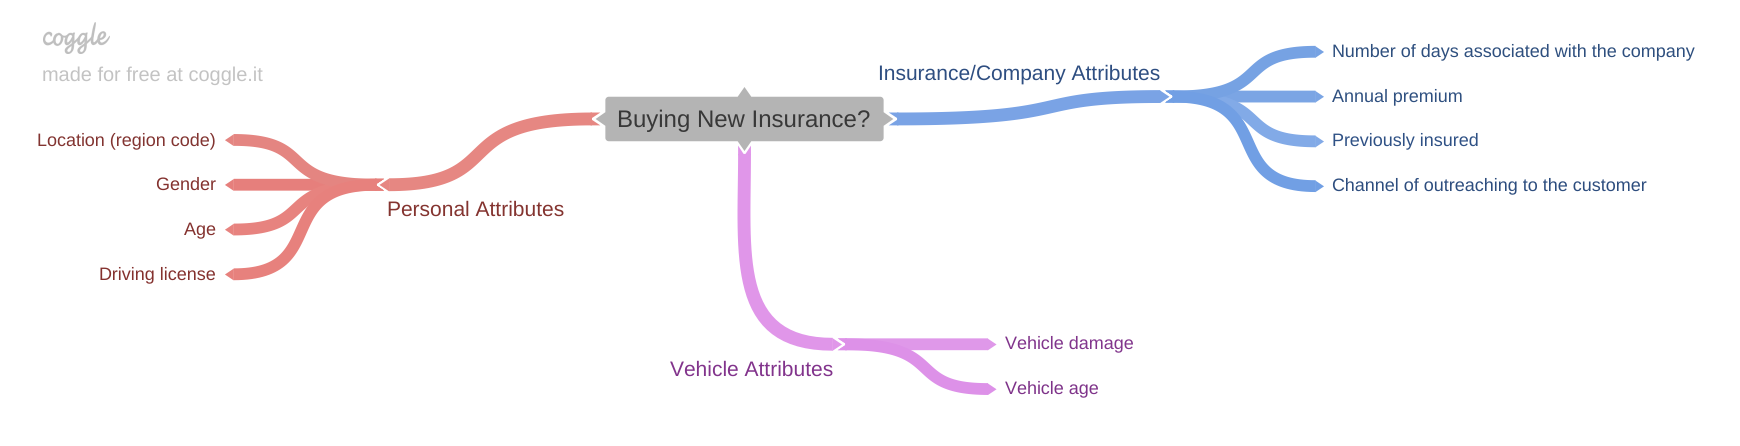

In [10]:
Image('C:/Users/bruno/OneDrive/Documentos/repos/pa-health-insurance-cross-sell/images/insurance.png', width=1250)

#### 3.2. **Hypotheses Creation**

3.2.1. **Personal Attributes Hypotheses**

- **H1:** Customers that have a driving license are more likely to buy the new vehicle insurance.
- **H2:** Customers in some locations are more likely to buy the new vehicle insurance, given the robbery rate, crash accidents occurrences, etc.
- **H2:** Older customers are more likely to buy the new vehicle insurance.

3.2.2. **Vehicle Attributes Hypotheses**

- **H1:** Customers with newer vehicles are more likely to buy vehicle insurance.
- **H2:** Customers that got their vehicle damaged in the past are more likely to buy the new vehicle insurance.

3.2.3. **Insurance/Company Attributes Hypotheses**

- **H1:** Customers that already have vehicle insurance are less likely to buy the new vehicle insurance.
- **H2:** Customers with lower annual premium are more likely to buy the new vehicle insurance.
- **H3:** Customers that have been in the company for a longer period are more likely to buy the new vehicle insurance.
- **H4:** Customers that have been reached out by some specific channels are more likely to buy the new vehicle insurance.

Unfortunately, there's no information regarding what each sales outreach channel is linked with each number. Also, there's no information on regions' robbery rate and crash accidents occurrences, etc. Therefore, 3.2.1 H2 and 3.2.3 H4 were dropped.

#### 3.3. **Final Hypotheses List**

- **H1:** Customers that have a driving license are more likely to buy the new vehicle insurance.
- **H2:** Older customers are more likely to buy the new vehicle insurance.
- **H3:** Customers with newer vehicles are more likely to buy vehicle insurance.
- **H4:** Customers that got their vehicle damaged in the past are more likely to buy the new vehicle insurance.
- **H5:** Customers that already have vehicle insurance are less likely to buy the new vehicle insurance.
- **H6:** Customers with lower annual premium are more likely to buy the new vehicle insurance.
- **H7:** Customers that have been in the company for a longer period are more likely to buy the new vehicle insurance.

#### 3.4. **Creating New Features**

In [11]:
df3['vehicle_age'] = df3['vehicle_age'].apply(lambda x: 'below_1_year' if x=='< 1 Year'
                                              else 'between_1_2_years' if x=='1-2 Year'
                                              else 'above_2_years')

In [12]:
df3['vehicle_damage'] = df3['vehicle_damage'].apply(lambda x: 0 if x=='No' 
                                                                else 1)

## 4. **Feature Filtering**

In [13]:
df4 = df3.copy()

There's no need to filter rows or columns for this dataset as nothing unusual has been found to the point that it wouldn't make sense business-wise.

## 5. **Exploratory Data Analysis (EDA)**

EDA main objectives are:
- Obtain business experience.
- Validate business hypotheses (insights).
- Find important features for the ML model. 

In [14]:
df5 = df4.copy()

#### 5.1. **Univariate Analysis**

5.1.1. **Response Variable**

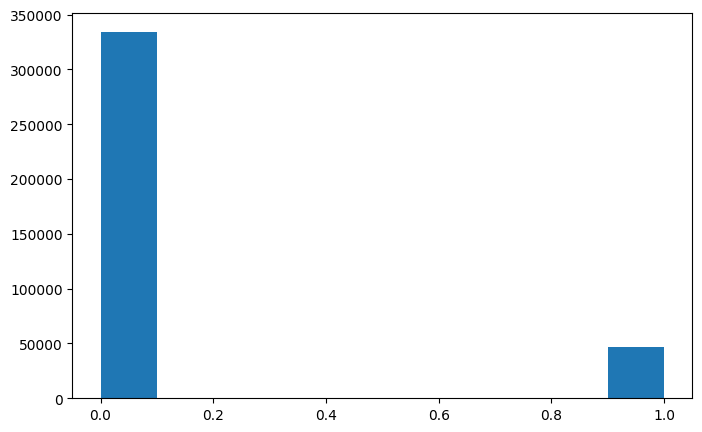

In [15]:
plt.figure(figsize=(8,5))
plt.hist(df5['response']);

In [16]:
buy = df5['response'].value_counts()[1]/len(df5['response'])*100

print(f'Only {round(buy,2)}% of customers are willing to buy the new vehicle insurance.')

Only 12.26% of customers are willing to buy the new vehicle insurance.


5.1.2. **Numerical Variables**

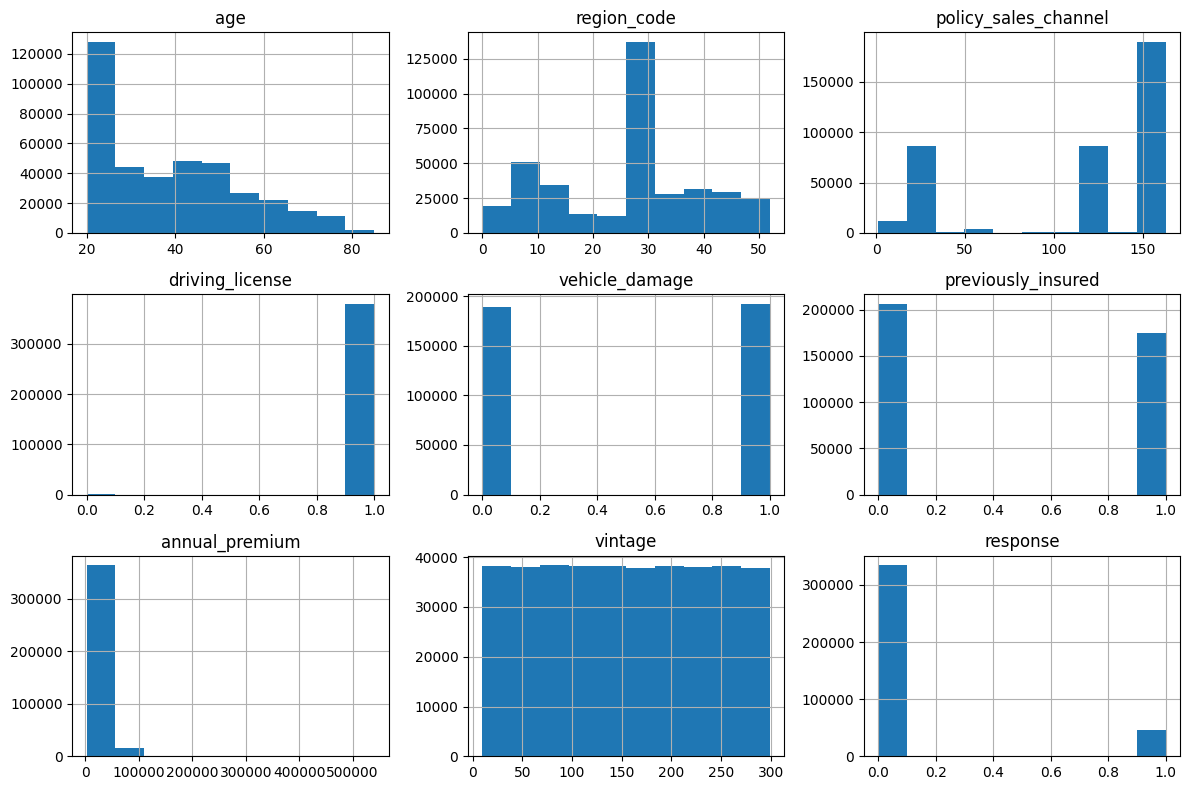

In [17]:
# Histogram plot for all numerical variables
num_attributes_new = df5.select_dtypes(include=['int64', 'float64']).drop(columns=['id'],axis=1)
num_attributes_new.hist(figsize=(12,8));
plt.tight_layout()
plt.show()

In [18]:
age_20_25 = len(df5[(df5['age']>=20)&(df5['age']<=25)]) # Age from 20-25
region_code_28 = len(df5[df5['region_code']==28]) # Region code 28
sales_channel_152 = len(df5[df5['policy_sales_channel']==152]) # Sale channel 152
driving_license_1 = len(df5[df5['driving_license']==1]) # Driving license
premium_2k_to_40k = len(df5[(df5['annual_premium']>=2630)&(df5['annual_premium']<=40000)]) # Annual premium from 2k to 40k

print(f'People from 20 to 25 years old = {round(age_20_25/len(df5),2)*100}%')
print(f'People in region code 28 = {round(region_code_28/len(df5),4)*100}%')
print(f'Sales channel 152 = {round(sales_channel_152/len(df5),2)*100}%')
print(f'People that own a driving license = {round(driving_license_1/len(df5),4)*100}%')
print(f'People with premiums from 2k to 40k per year = {round(premium_2k_to_40k/len(df5),4)*100}%')

People from 20 to 25 years old = 30.0%
People in region code 28 = 27.92%
Sales channel 152 = 35.0%
People that own a driving license = 99.79%
People with premiums from 2k to 40k per year = 76.39%


- About 30% of people are 20 to 25 years old in the dataset.
- About 28% of people are located at region 28.
- Sales channel 152 represents about 1/3 of customers outreach.
- Almost everyone in the dataset own a driving license.
- Over 3/4 of people have their annual premiums set at US$ 2,630 (min) to around US$ 40,000.

5.1.3. **Categorical Variables**

There're only two categorical variables to analyze:
- Gender
- Vehicle Age 

*Even though Vehicle Age is numerical, for this particular dataset, I'll be considering it as categorical for now, since it didn't go through any encoding transformation yet.*

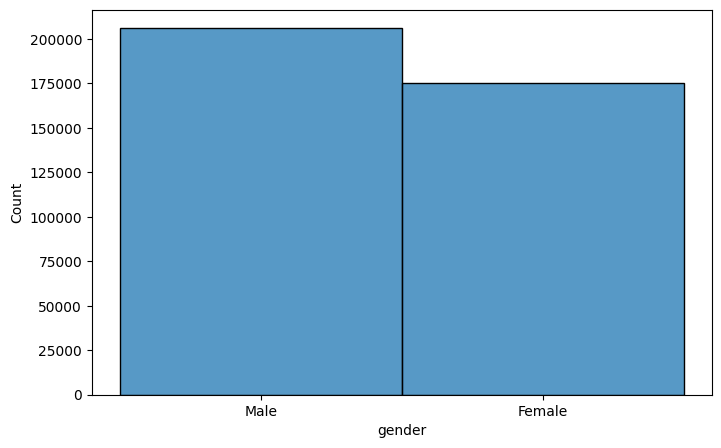

In [19]:
plt.figure(figsize=(8,5))
sns.histplot(data=df5, x='gender');

In [20]:
men_perc = df5['gender'].value_counts()[0]/len(df5)*100

print(f'About {round(men_perc,2)}% of the dataset is composed of men.')

About 54.08% of the dataset is composed of men.


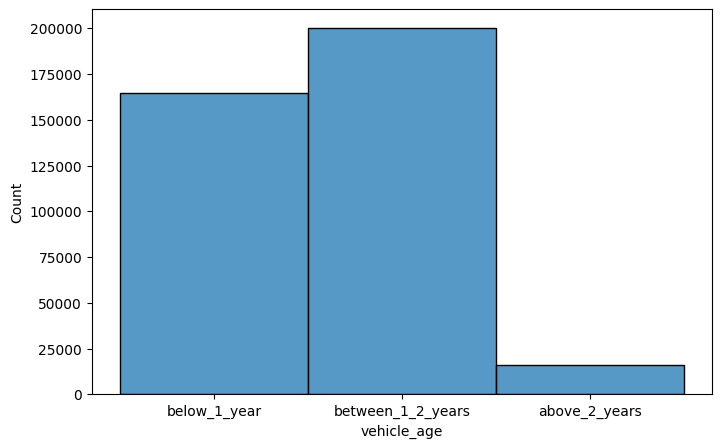

In [21]:
plt.figure(figsize=(8,5))
sns.histplot(data=df5, x='vehicle_age');

In [22]:
age_below_2 = (len(df5) - df5['vehicle_age'].value_counts()[2])/(len(df5))*100

print(f'About {round(age_below_2,2)}% of vehicles are less than 2 years old.')

About 95.8% of vehicles are less than 2 years old.


- There's slightly more men than women in the dataset.
- Only 5% of vehicles are older than two years.

#### 5.2. **Bivariate Analysis (Checking Hypotheses)**

##### **H1:** Customers that have a driving license are more likely to buy the new vehicle insurance.
**TRUE**: Customers that have a driving license are more likely to buy the new vehicle insurance.

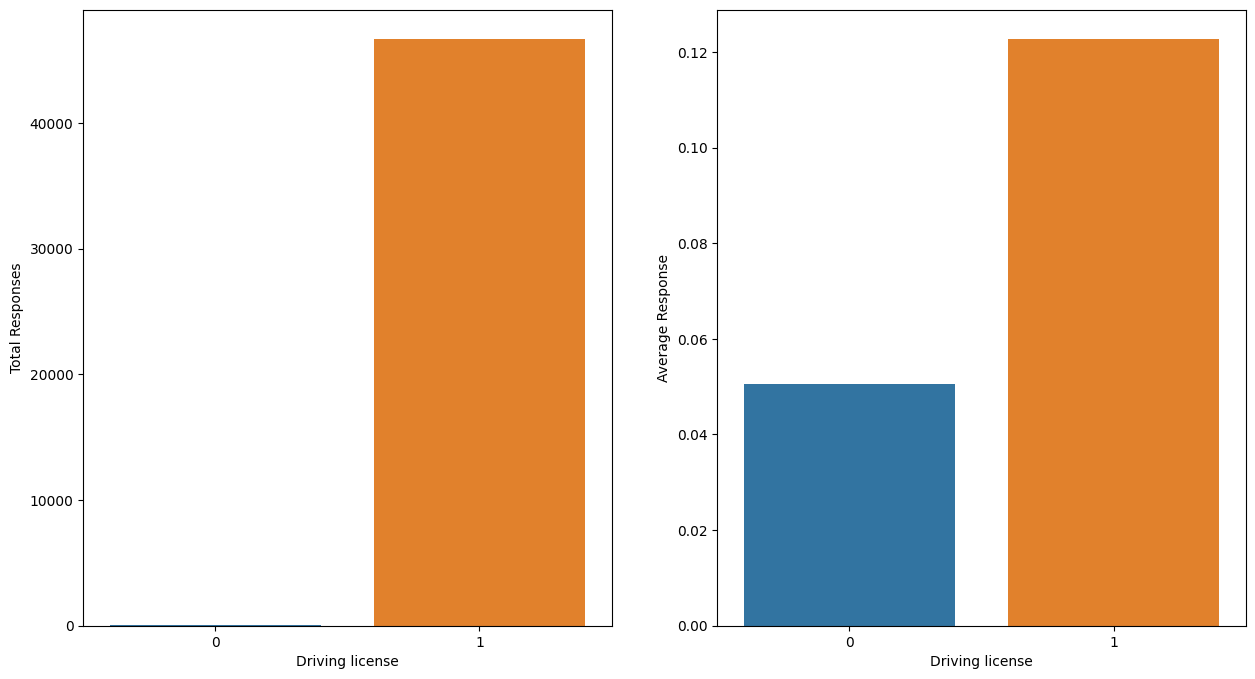

In [23]:
aux = df5[['response','driving_license']].groupby('driving_license').sum().reset_index()
aux2 = df5[['response','driving_license']].groupby('driving_license').mean().reset_index()

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
sns.barplot(x='driving_license',y='response', data=aux);
plt.xlabel('Driving license')
plt.ylabel('Total Responses');

plt.subplot(1,2,2)
sns.barplot(x='driving_license',y='response', data=aux2);
plt.xlabel('Driving license')
plt.ylabel('Average Response');

##### **H2:** Older customers are more likely to buy the new vehicle insurance.

**TRUE**: Older customers are more likely to buy the new vehicle insurance.

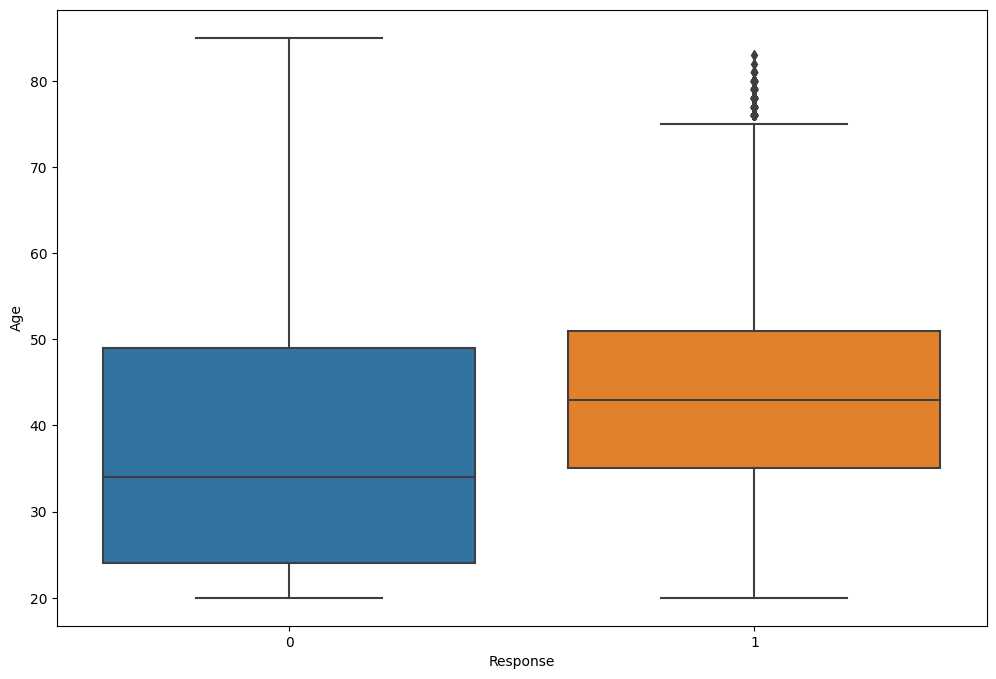

In [24]:
plt.figure(figsize=(12,8))
sns.boxplot(x='response',y='age', data=df5);
plt.xlabel('Response')
plt.ylabel('Age');

##### **H3:** Customers with newer vehicles are more likely to buy vehicle insurance.

**FALSE**: Customers with older vehicles are more likely to buy vehicle insurance.

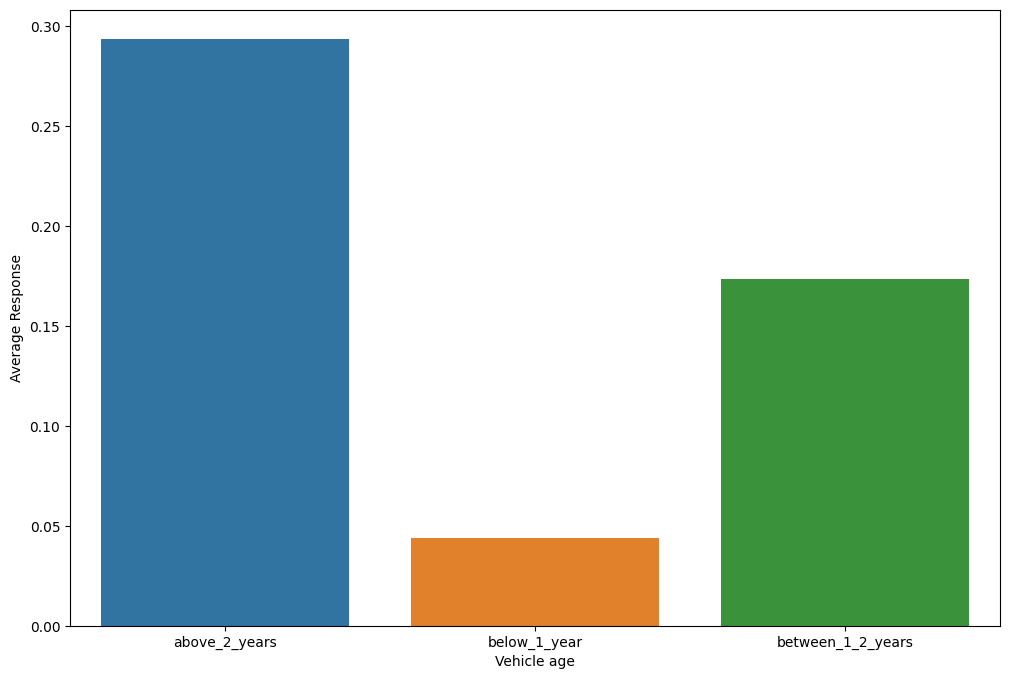

In [25]:
aux = df5[['vehicle_age','response']].groupby('vehicle_age').mean().reset_index()

plt.figure(figsize=(12,8))
sns.barplot(x='vehicle_age', y='response', data=aux);
plt.xlabel('Vehicle age')
plt.ylabel('Average Response');

The average response was used here, due to major differences in the amount of people in each vehicle age range.

##### **H4:** Customers that got their vehicle damaged in the past are more likely to buy the new vehicle insurance.

**TRUE**: Customers that got their vehicle damaged in the past are more likely to buy the new vehicle insurance.

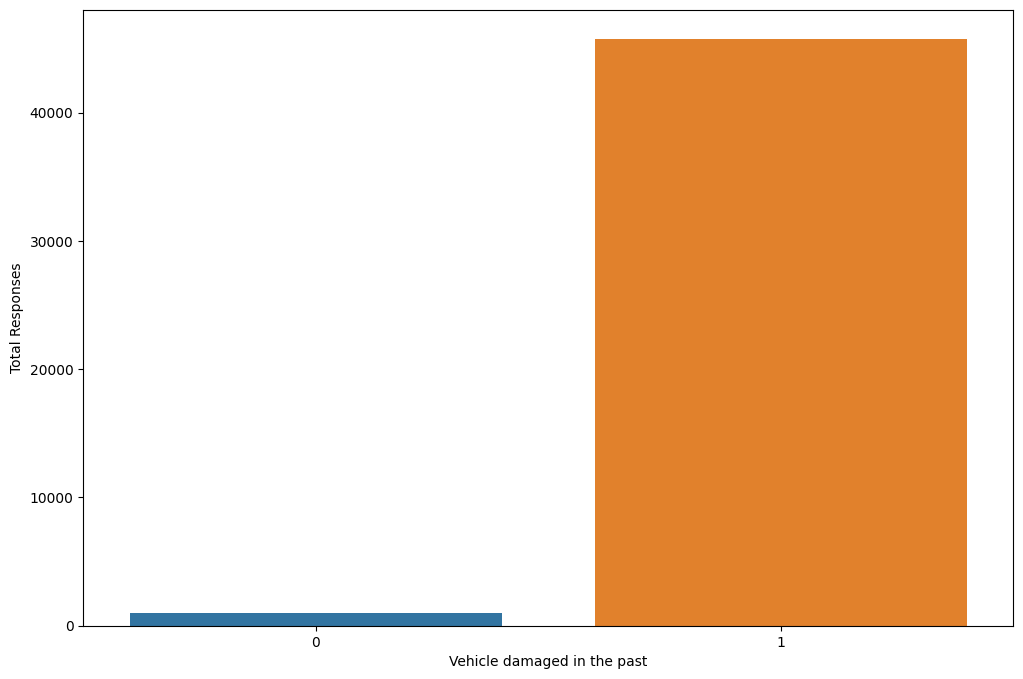

In [26]:
aux = df5[['vehicle_damage', 'response']].groupby('vehicle_damage').sum().reset_index()

plt.figure(figsize=(12,8))
sns.barplot(x='vehicle_damage',y='response', data=aux)
plt.xlabel('Vehicle damaged in the past')
plt.ylabel('Total Responses');

##### **H5:** Customers that already have vehicle insurance are less likely to buy the new vehicle insurance.

**TRUE**: Only 0.34% of people that want the new insurance already have another vehicle insurance.

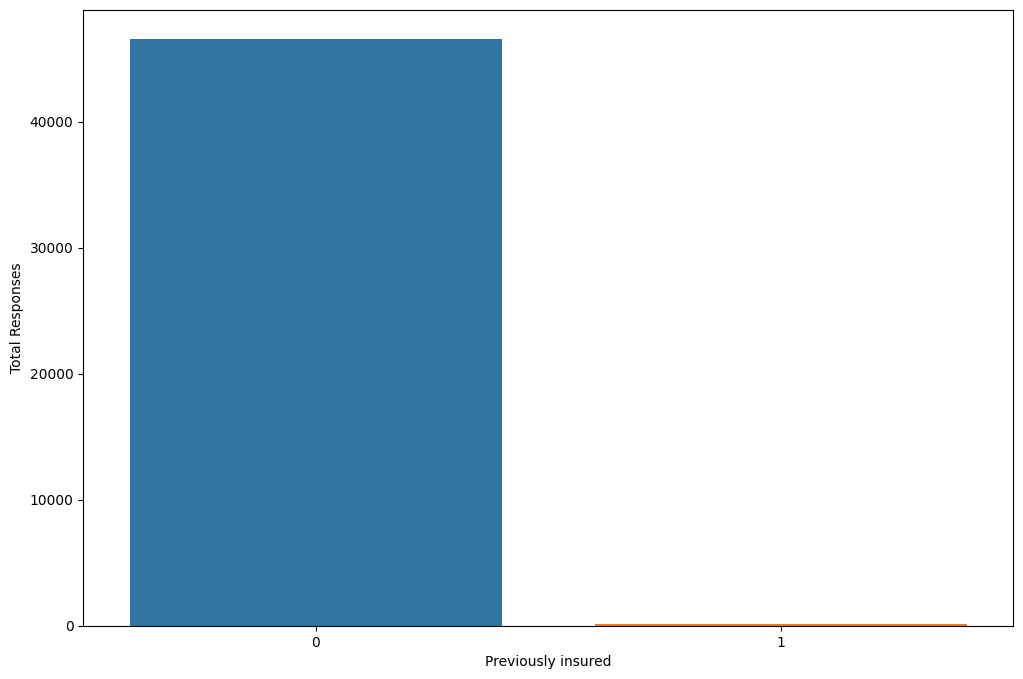

In [27]:
aux = df5[['previously_insured', 'response']].groupby('previously_insured').sum().reset_index()

plt.figure(figsize=(12,8))
sns.barplot(x='previously_insured',y='response', data=aux)
plt.xlabel('Previously insured')
plt.ylabel('Total Responses');

In [28]:
prev_perc = aux['response'][0]/aux['response'].sum()

print(f'Amount of people that want the new vehicle insurance buy already have another vehicle insurance = {round((1 - prev_perc)*100,2)}%')

Amount of people that want the new vehicle insurance buy already have another vehicle insurance = 0.34%


##### **H6:** Customers with lower annual premium are more likely to buy the new vehicle insurance.

**FALSE**: There's no clear relation between annual premium cost and average response per range.

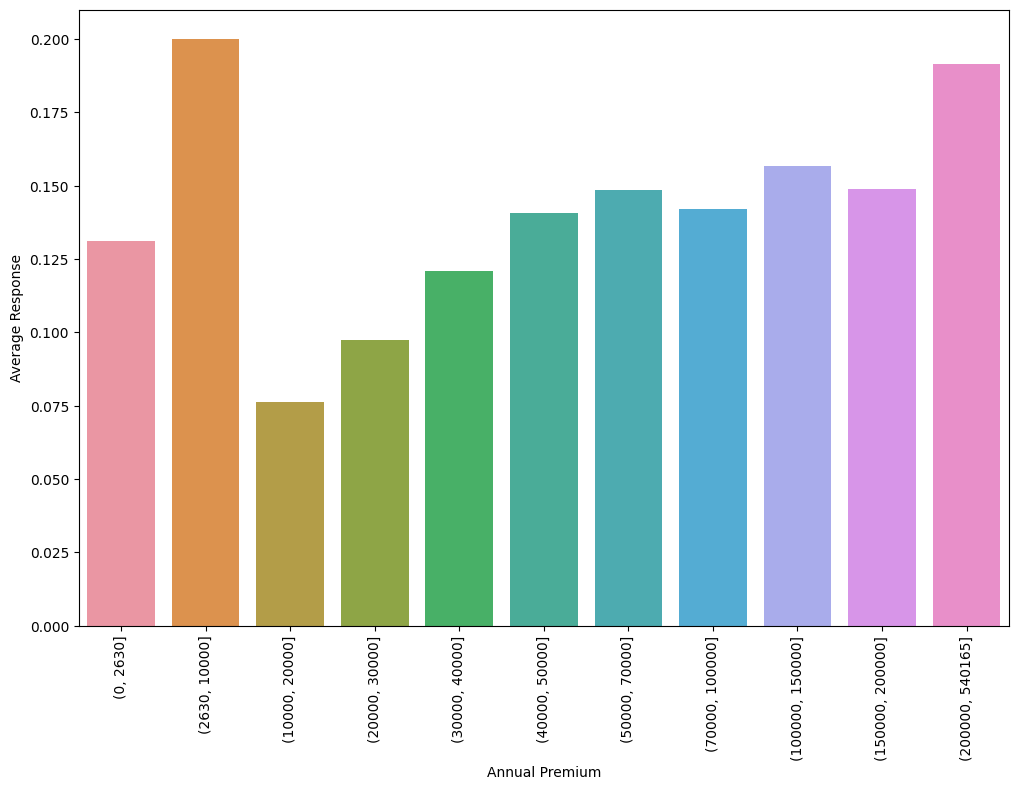

In [29]:
aux = df5[['annual_premium', 'response']].groupby('annual_premium').mean().reset_index()
bins = [0, 2630, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 150000, 200000, 540165] # Setting the barplot bins
aux['annual_premium_binned'] = pd.cut(aux['annual_premium'], bins=bins)
aux2 = aux[['annual_premium_binned','response']].groupby('annual_premium_binned').mean().reset_index()

plt.figure(figsize=(12,8))
sns.barplot(x='annual_premium_binned',y='response', data=aux2)
plt.xlabel('Annual Premium')
plt.ylabel('Average Response')
plt.xticks(rotation=90) # Rotating the x axis for better visualization 
plt.ticklabel_format(style='plain', axis='y')
plt.show()

The average response was used here, due to major differences in the amount of people in each annual premium range.

##### **H7:** Customers that have been in the company for a longer period are more likely to buy the new vehicle insurance.

**FALSE**: There's no clear relation between how long a customer has been in the company and response per range.

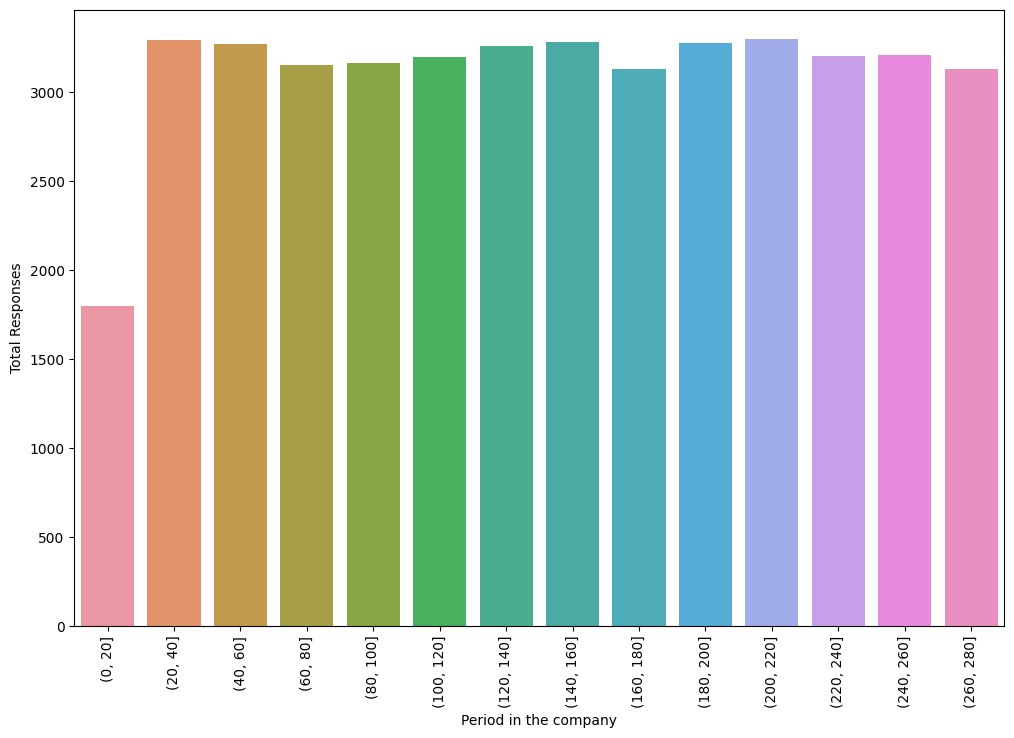

In [30]:
aux = df5[['vintage','response']].groupby('vintage').sum().reset_index()
bins = list(np.arange(0,300,20)) # Setting the barplot bins
aux['vintage_binned'] = pd.cut(aux['vintage'], bins=bins)
aux2 = aux[['vintage_binned','response']].groupby('vintage_binned').sum().reset_index()

plt.figure(figsize=(12,8))
sns.barplot(x='vintage_binned',y='response', data=aux2)
plt.xlabel('Period in the company')
plt.ylabel('Total Responses')
plt.xticks(rotation=90) # Rotating the x axis for better visualization 
plt.ticklabel_format(style='plain', axis='y')
plt.show()

5.2.1. **Hypotheses Summary**

| **Hypothesis** |    **Variable**    | **Hypothesis Conclusion** | **Expected Relevance** |
|:--------------:|:------------------:|:-------------------------:|:----------------------:|
| H1             | driving_license    | True                      | High                   |
| H2             | age                | True                      | Medium                 |
| H3             | vehicle_age        | False                     | Medium                 |
| H4             | vehicle_damage     | True                      | High                   |
| H5             | previously_insured | True                      | High                   |
| H6             | annual_premium     | False                     | Low                    |
| H7             | vintage            | False                     | Low                    |

Obs: **Expected Relevance** represents the ESTIMATED importance of each hypothesis for the algorithm. This estimation is purely based on business knowledge, as well as in the above analysis. For some hypotheses the estimated relevance could be wrong (when evaluating the fitted model). 

## FAZER FUNCAO BINNED BAR PLOT

#### 5.3. **Multivariate Analysis**

5.3.1. **Numerical Variables**

In order to check correlation between all numerical variables in the dataset a pearson correlation will be displayed below:

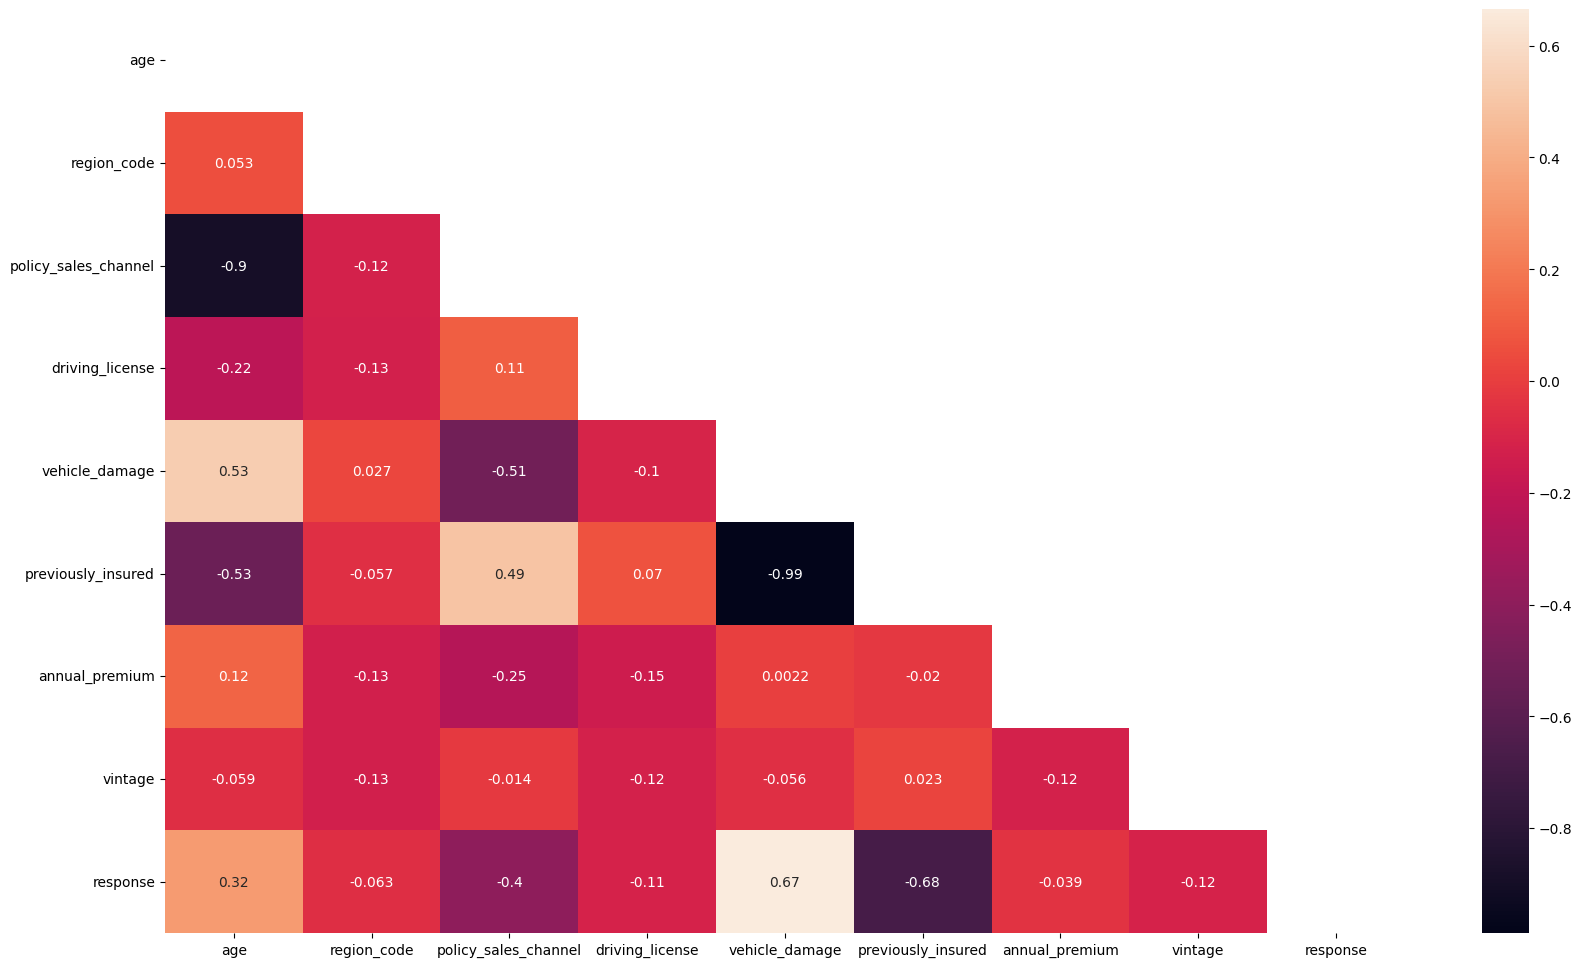

In [31]:
corr = num_attributes_new.corr(method='pearson').corr() # Pearson Corr
mask = np.triu(corr) # Cleaner heatmap - Only plotting the lower triangle

plt.figure(figsize=(20,12)) # Heatmap size
sns.heatmap(corr, annot=True, mask=mask);

5.3.2. **Categorical Variables**

In order to check correlation between all categorical variables (gender and vehicle_age) in the dataset a Cramér's V correlation matrix will be displayed below:

In [32]:
df5.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage            int64
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

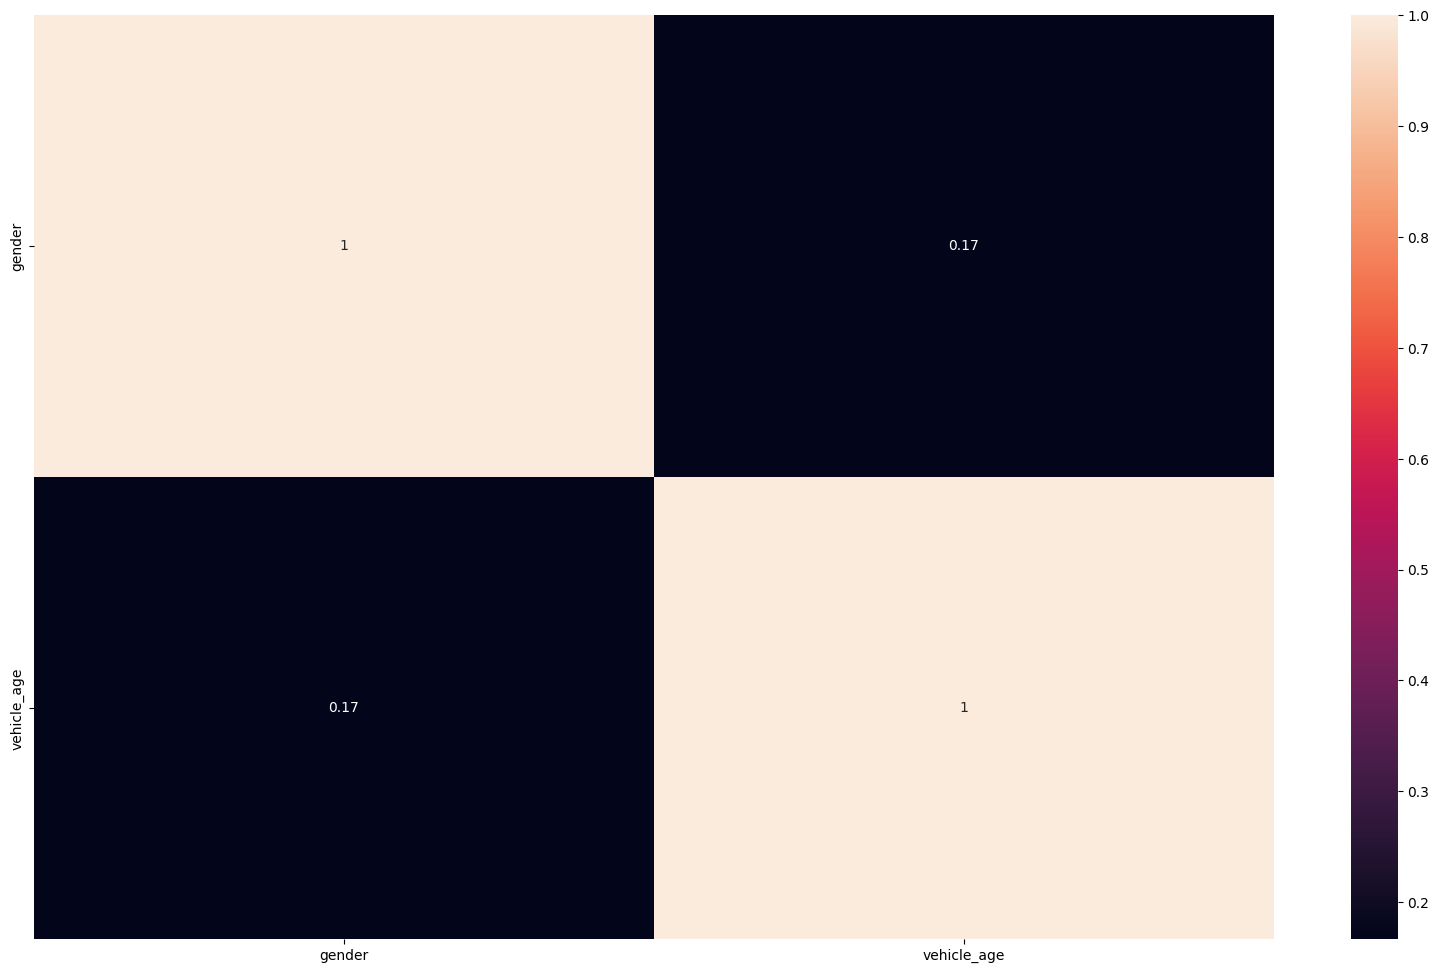

In [33]:
cat = df5.select_dtypes(include='object') # Select only categorical data
cramers_matrix(cat)

## 6. **Data Preparation**

In [34]:
df6 = df5.copy()

In [35]:
df6.columns.drop('id')

Index(['gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

**Variables that will be rescaled**:
- age
- vintage
- annual_premium

**Variables that will be encoded**:
- gender
- region_code
- vehicle_age
- policy_sales_channel

**Variables that will remain the same, because those are already binary**:
- driving_license
- vehicle_damage
- previously_insured
- response

#### 6.1. **Rescaling**

The selected rescaling methods for this dataset are: Robust Scaler and Min Max Scaler. Robust Scaler is mostly used to deal with outliers, its formula is: 

${x}' =  \frac{x_{i} - Q_{1}(x)}{Q_{3}(x)- Q_{1}(x)}$

Whereas Min Max Scaler can be used when no significant outliers are present:

${x}' =  \frac{x - x_{min}}{x_{max} - x_{min}}$

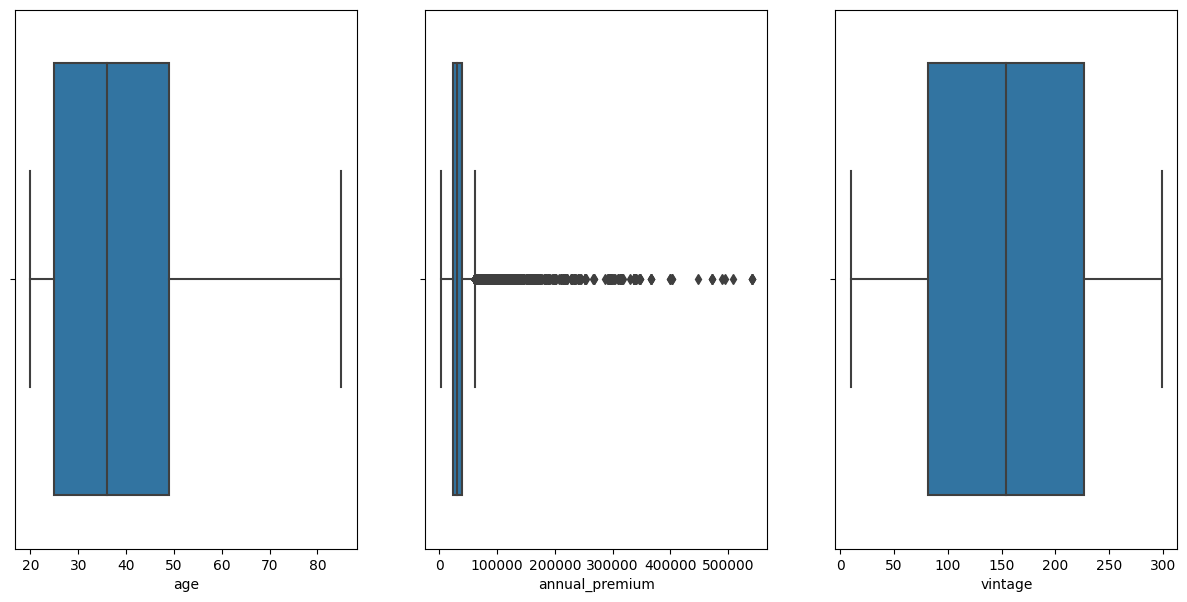

In [36]:
# Numerical variables boxplot
plt.figure(figsize=(15,7))            

plt.subplot(1,3,1)
sns.boxplot(x = df6['age'], orient='h')

plt.subplot(1,3,2)
sns.boxplot(x = df6['annual_premium'], orient='h')

plt.subplot(1,3,3)
sns.boxplot(x = df6['vintage'], orient='h');

Robust Scaler will be used for the annual_premium variable, whereas for age and vintage Min Max Scaler will be applied.

In [37]:
# age - MinMaxScaler
mms_age = MinMaxScaler()
df6['age'] = mms_age.fit_transform(df6[['age']].values)

# vintage - MinMaxScaler
mms_vintage = MinMaxScaler()
df6['vintage'] = mms_vintage.fit_transform(df6[['vintage']].values)

# RobustScaler - annual_premium
rs = RobustScaler()
df6['annual_premium'] = rs.fit_transform(df6[['annual_premium']].values)

#### 6.2. **Encoding**

6.2.1. **One Hot Encoding - gender**

One hot encoding creates n columns based on n labels present in the original column, assigning binary values to each new column. In this case, columns female and male will be created.

In [38]:
# gender
df6 = pd.get_dummies(df6, prefix=['gender'], columns=['gender']).rename(columns={'gender_Female': 'female', 'gender_Male': 'male'})

6.2.2. **Target Encoding - policy_sales_channel and region_code**

Target encoding is the process of replacing a categorical value with the mean of the target variable. 

In [39]:
# Both policy_sales_channel and region_code have to be transformed to object type, so that the TargetEncoder can identify those as categorical variables.
df6['region_code'] = df6['region_code'].astype(str)
df6['policy_sales_channel'] = df6['policy_sales_channel'].astype(str)

In [40]:
# region_code
te_region_code = TargetEncoder()
df6['region_code'] = te_region_code.fit_transform(X=df6[['region_code']].values, y=df6[['response']].values)

# policy_sales_channel 
te_policy_sales_channel = TargetEncoder()
df6['policy_sales_channel'] = te_policy_sales_channel.fit_transform(X=df6[['policy_sales_channel']].values, y=df6[['response']].values)

6.2.3. **Ordinal Encoding - vehicle_age**

This type of encoding converts each label into ordered integer values, in this case:
- below_1_year -> 1
- between_1_2_years -> 2
- above_2_years -> 3

And then, after rescaling:
- below_1_year -> 0
- between_1_2_years -> 0.5
- above_2_years -> 1

In [41]:
# vehicle_age
oe = OrdinalEncoder()
mapping = {'below_1_year': 1, 'between_1_2_years': 2, 'above_2_years': 3} # mapping ordered values
df6['vehicle_age'] = oe.fit_transform(X=df6[['vehicle_age']].values, y=df6[['response']].values, mapping=mapping)

# Now rescaling new vehicle_age - MinMaxScaler
mms_vehicle_age = MinMaxScaler()
df6['vehicle_age'] = mms_vehicle_age.fit_transform(df6[['vehicle_age']].values)

## 7. **Feature Selection**

In [42]:
df7 = df6.copy()

#### 7.1. **Split dataframe into training and test dataset**

In [43]:
X = df7.drop(columns=['response'], axis=1) # dropping target column
y = df7['response'].copy()

X_train, X_validation, y_train, y_validation = train_test_split(X, 
                                                                y, 
                                                                test_size=0.2, 
                                                                random_state=42) # Using 20% for validation

#### 7.2. **Random Forest as a Feature Selector**

Random Forest (RF) implements bagging method and decision trees, by resampling a random subset of the features and fitting each subset by using a decision tree. At the end, the predictions, in classification problems, are based on soft voting. (**VER SE É ISSO MESMO**)

Due to its nature, RF is often used as a feature selector, since each tree calculates the importance of a feature according to its power in increasing leaves' pureness.

A function was created in order to provide a list and a plot of ranked importances, given by the chosen model (RF in this case).

In [44]:
X_train_n = X_train.drop('id', axis=1) # Removing the id for training the RF
y_train_n = y_train.values # Getting the y_train as an array

In [45]:
# # Defining the RF model
# rf = RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)

# # Using the feature_importances function
# feature_importances(rf, X_train_n, y_train_n)

#### 7.3. **Selecting the Features**

Seven features were selected, as provided by the RF model. 

In [46]:
cols_selected = ['vintage',
                 'annual_premium',
                 'age',
                 'region_code',
                 'policy_sales_channel',
                 'vehicle_damage',
                 'previously_insured']

**Expectation vs Reality** considering what was expected on the 5.2.1. section (Hypotheses Summary) regarding features relevance:


| **Hypothesis** |    **Variable**    | **Hypothesis Conclusion** | **Expected Relevance** | **Relevant based on RF model?** |
|:--------------:|:------------------:|:-------------------------:|:----------------------:|:-------------------------------:|
|       H1       |   driving_license  |            True           |          High          |                No               |
|       H2       |         age        |            True           |         Medium         |               Yes               |
|       H3       |     vehicle_age    |           False           |         Medium         |                No               |
|       H4       |   vehicle_damage   |            True           |          High          |               Yes               |
|       H5       | previously_insured |            True           |          High          |               Yes               |
|       H6       |   annual_premium   |           False           |           Low          |               Yes               |
|       H7       |       vintage      |           False           |           Low          |               Yes               |                          |

## 8. **Machine Learning Modeling**

As we're ranking customers in a list, there's no need to look into the more traditional classification metrics, such as accuracy, precision, recall, f1-score, aoc-roc curve, confusion matrix, etc.

Instead, **ranking metrics** will be used:

- **Precision at K** : Shows the fraction of correct predictions made until K out of all predictions. 
  
- **Recall at K** : Shows the fraction of correct predictions made until K out of all true examples. 

In addition, the **Cumulative Gains Curve** can be plotted, indicating the percentage of customers, ordered by probability score, containing a percentage of all customers interested in the new insurance.  

**For this business problem, Precision at K is by far the most important metric to evaluate model performance, since it shows how many predictions (in percentage) are correct until K, out of all predictions made.**



In [47]:
# Train and Validation Split 
X_train_ml = X_train_n[cols_selected]
y_train_ml = y_train.values

X_val = X_validation[cols_selected]
y_val = y_validation.values

Seven models will be trained:

- KNN Classifier
- Logistic Regression
- Random Forest Classifier
- AdaBoost Classifier
- CatBoost Classifier
- XGBoost Classifier 
- Light GBM Classifier

For each model there'll be two snippets:

- The first one fits the data without cross-validation. This is used for a overview visualization of the model, as well as for plotting the cumulative gains curve. 
  
- The second one fits the data using cross-validation, returning Precision at K, Recall at K and ROC AUC Score metrics, where k equals 20000, given our business problem.

#### 8.1. **KNN**

In [66]:
# # KNN
# model_knn = KNeighborsClassifier(n_neighbors=5).fit(X_train_ml, y_train_ml) # fitting the model

# y_hat_knn = model_knn.predict_proba(X_val) # getting the probabilities 

# plot_cumulative_gain(y_validation, y_hat_knn); # plotting the cumulative gain curve

In [67]:
# model_knn_cv = KNeighborsClassifier(n_neighbors=5).fit(X_train_ml, y_train_ml)
# cv_knn = cross_validation(model_knn_cv, X_train_ml, y_train, 5, verbose=False)

#### 8.2. **Logistic Regression**

In [68]:
# # Logistic Regression
# model_lr = LogisticRegression(random_state=42).fit(X_train_ml, y_train_ml) # fitting the model

# y_hat_lr = model_lr.predict_proba(X_val) # getting the probabilities 

# plot_cumulative_gain(y_validation, y_hat_lr); # plotting the cumulative gain curve

In [69]:
# model_lr_cv = LogisticRegression(random_state=42)

# cv_lr = cross_validation(model_lr_cv, X_train_ml, y_train, 5, verbose=False)

#### 8.3. **Random Forest**

In [70]:
# # Random Forest
# model_rf = RandomForestClassifier(n_estimators=1000,
#                                   random_state=42).fit(X_train_ml, y_train_ml) # fitting the model
              
# y_hat_rf = model_rf.predict_proba(X_val) # getting the probabilities 

# plot_cumulative_gain(y_validation, y_hat_rf); # plotting the cumulative gain curve

In [71]:
# model_rf_cv = RandomForestClassifier(n_estimators=1000,
#                                      random_state=42)
# cv_rf = cross_validation(model_rf_cv, X_train_ml, y_train, 5, verbose=False)

#### 8.4. **AdaBoost**

In [72]:
# # AdaBoost
# model_ada = AdaBoostClassifier(n_estimators=1000,
#                                random_state=42).fit(X_train_ml, y_train_ml) # fitting the model
              
# y_hat_ada = model_ada.predict_proba(X_val) # getting the probabilities 

# plot_cumulative_gain(y_validation, y_hat_ada); # plotting the cumulative gain curve

In [73]:
# model_ada_cv = AdaBoostClassifier(n_estimators=1000,
#                                  verbose=False,
#                                  random_state=42)
# cv_ada = cross_validation(model_ada_cv, X_train_ml, y_train, 5, verbose=False)

#### 8.5. **CatBoost**

In [74]:
# # CatBoost
# model_cb = CatBoostClassifier(n_estimators=1000,
#                               verbose=False,
#                               random_state=42).fit(X_train_ml, y_train_ml) # fitting the model
              
# y_hat_cb = model_cb.predict_proba(X_val) # getting the probabilities 

# plot_cumulative_gain(y_validation, y_hat_cb); # plotting the cumulative gain curve

In [75]:
# model_cb_cv = CatBoostClassifier(n_estimators=1000,
#                                  verbose=False,
#                                  random_state=42)
# cv_cb = cross_validation(model_cb_cv, X_train_ml, y_train, 5, verbose=False)

#### 8.6. **XGBoost**

In [76]:
# # XGBoost
# model_xgb = XGBClassifier(n_estimators=1000,
#                           random_state=42).fit(X_train_ml, y_train_ml) # fitting the model
              
# y_hat_xgb = model_xgb.predict_proba(X_val) # getting the probabilities 

# plot_cumulative_gain(y_validation, y_hat_xgb); # plotting the cumulative gain curve

In [77]:
# model_xgb_cv = XGBClassifier(n_estimators=1000,
#                              random_state=42)
# cv_xgb = cross_validation(model_xgb_cv, X_train_ml, y_train, 5, verbose=False)

#### 8.7. **Light GBM**

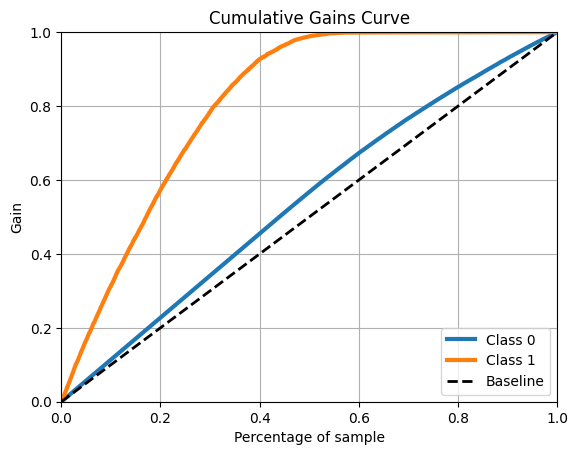

In [58]:
# Light GBM - Plot cumulative gain curve
model_lgbm = LGBMClassifier(n_estimators=1000,
                            random_state=42).fit(X_train_ml, y_train_ml)
              
y_hat_lgbm = model_lgbm.predict_proba(X_val) # getting the probabilities 
plot_cumulative_gain(y_validation, y_hat_lgbm); # plotting the cumulative gain curve

In [100]:
# Light GBM - Cross Validation
model_lgbm_cv = LGBMClassifier(_estimators=1000,
                               random_state=42)
cv_lgbm = cross_validation(model_lgbm_cv, X_train_ml, y_train, 5, verbose=False)

#### 8.8. **Comparing Models Performance**

In [60]:
models_performance = pd.concat([cv_knn, cv_lr, cv_cb, cv_xgb, cv_lgbm])
models_performance.sort_values('Precision at K', ascending=False)

,Model,Precision at K,Recall at K,ROC AUC Score
0,CatBoostClassifier,0.3096 +/- 0.0014,0.8266 +/- 0.0036,0.8531 +/- 0.0016
0,LGBMClassifier,0.3075 +/- 0.0012,0.821 +/- 0.0033,0.8505 +/- 0.0016
0,LogisticRegression,0.3058 +/- 0.0012,0.8165 +/- 0.0033,0.8427 +/- 0.0021
0,XGBClassifier,0.2995 +/- 0.0022,0.7998 +/- 0.0059,0.8397 +/- 0.0018
0,KNeighborsClassifier,0.2738 +/- 0.003,0.7311 +/- 0.008,0.7568 +/- 0.0035


The **Light GBM Classifier** model will be chosen for hyperparameter tuning, since it provided the second best result in all three metrics, whilst being by far the faster algorithm to train and tune. 

**LGBM speed** in comparison to other ensemble algorithms trained in this dataset:
- 4.7 times faster than CatBoost 
- 7.1 times faster than XGBoost
- 30.6 times faster than AdaBoost
- 63.2 times faster than Random Forest

## FALAR SOBRE NAO TER PROBLEMA A PRECISION BAIXA ASSIM

## 9. **Hyperparameter Fine Tuning**

#### 9.1. **Bayesian Optimization**

An important task in ML modeling is Hyperparameter Tuning, on which the goal is to find the **best possible combination of model hyperparameters**. One way of doing this is via Bayesian Optimization, by using the <a href="https://optuna.org/">Optuna</a> library. This is how it works:

- A set of possible model hyperparameters (search space) is defined.
  
- It starts searching random combinations of these parameters and training each model.
  
- Then, Optuna uses a history record of trials to determine which hyperparameter values to try next, by trying to find the most promising hyperparameters to be tuned.
  
- The metrics for each model are saved for latter comparison.

Bayesian Optimization is definitely more efficient in comparison to Grid Search and Random Search, since it's much faster than Grid Search, and it goes through better (smarter) hyperparameters combination than Random Search, meaning that it considers hyperparameters differently in terms of model impact.

In [143]:
def bayesian_opt_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 1000, 2000, step=100)
    learning_rate = trial.suggest_float('learning_rate', 0.015, 0.05, step=0.005)
    num_leaves = trial.suggest_int('num_leaves', 40, 160, step=5)
    max_depth = trial.suggest_int('max_depth', 5, 10, step=1)
    min_split_gain = trial.suggest_float('min_split_gain', 0.01, 0.1, step=0.005)
    min_child_samples = trial.suggest_int('min_child_samples', 40, 160, step=5)
    subsample = trial.suggest_float('subsample', 0.7, 1, step=0.05)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.7, 1, step=0.05)
    neg_bagging_fraction = trial.suggest_float('neg_bagging_fraction', 0.1, 0.9, step=0.05)
    
    lgbm = LGBMClassifier(n_estimators = n_estimators,
                          learning_rate = learning_rate, 
                          num_leaves = num_leaves, 
                          max_depth = max_depth,
                          min_split_gain = min_split_gain,
                          min_child_samples = min_child_samples,
                          subsample = subsample,
                          colsample_bytree = colsample_bytree,
                          neg_bagging_fraction=neg_bagging_fraction,
                          random_state=42).fit(X_train_ml, y_train)

    yhat_lgbm_proba = lgbm.predict_proba(X_val)
        
    data = X_val.copy()
    data['response'] = y_validation.copy()
    data['score'] = yhat_lgbm_proba[:,1].tolist()

    data = data.sort_values('score',ascending=False)

    precision_k_20000 = precision_at_k(data)

    return precision_k_20000

In [144]:
study = optuna.create_study(direction='maximize') # maximizing the precision at k
study.optimize(bayesian_opt_objective, n_trials=3500); # optimizing the defined function and setting the number of trials
trial = study.best_trial

print(f'Best Precision at K = {trial.value}')
print(f'Best Hyperparameters = {trial.params}')

[I 2022-10-21 22:17:24,732] A new study created in memory with name: no-name-a2d85c3a-80e2-4610-a532-ec82b62a9179
[I 2022-10-21 22:17:34,512] Trial 0 finished with value: 0.3297835108244588 and parameters: {'n_estimators': 1000, 'learning_rate': 0.045, 'num_leaves': 60, 'max_depth': 8, 'min_split_gain': 0.01, 'min_child_samples': 70, 'subsample': 1.0, 'colsample_bytree': 0.95, 'neg_bagging_fraction': 0.35}. Best is trial 0 with value: 0.3297835108244588.
[I 2022-10-21 22:17:41,887] Trial 1 finished with value: 0.3329833508324584 and parameters: {'n_estimators': 1000, 'learning_rate': 0.04, 'num_leaves': 160, 'max_depth': 6, 'min_split_gain': 0.08499999999999999, 'min_child_samples': 160, 'subsample': 0.7999999999999999, 'colsample_bytree': 0.7999999999999999, 'neg_bagging_fraction': 0.2}. Best is trial 1 with value: 0.3329833508324584.
[I 2022-10-21 22:17:51,102] Trial 2 finished with value: 0.3318834058297085 and parameters: {'n_estimators': 1100, 'learning_rate': 0.045, 'num_leaves':

#### 9.2. **Final Model**

The Bayesian Optimization with Optuna provided the following hyperparameters as the best ones tested:

| Hyperparameter | Definition | Best Value |
|:---:|:---:|:---:|
| n_estimators | Number of boosting iterations | 4500 |
| learning_rate | Shrinkage rate | 0.03 |
| num_leaves | Max number of leaves in one tree | 128 |
| max_depth | Limit the max depth for tree model | 8 |
| min_split_gain |Minimum loss reduction required to make a further partition on a leaf node of the tree | |
| min_child_samples | Minimal number of data in one leaf | 100 |
| subsample | Used to randomly select part of data without resampling| 0.7 |
| colsample_bytree| Used to randomly select a subset of features on each iteration| 0.9 |


For evaluating the final model not only Precision at K, Recall at K and Cumulative Gain Curve will be calculated, but also the Lift Curve, which indicates how many times the ML model is better than the baseline model.

,Model,Precision at K,Recall at K
0,LGBMClassifier,0.33458,0.72299


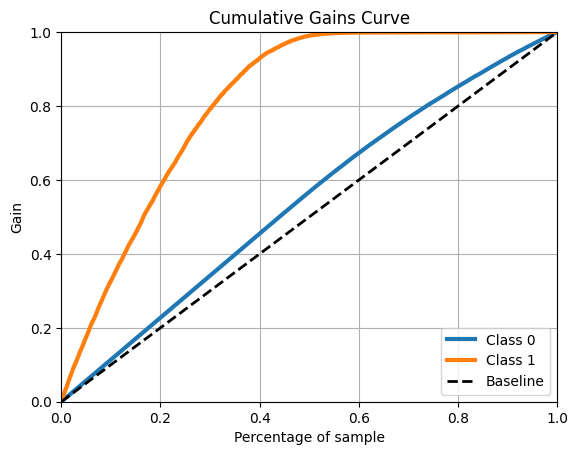

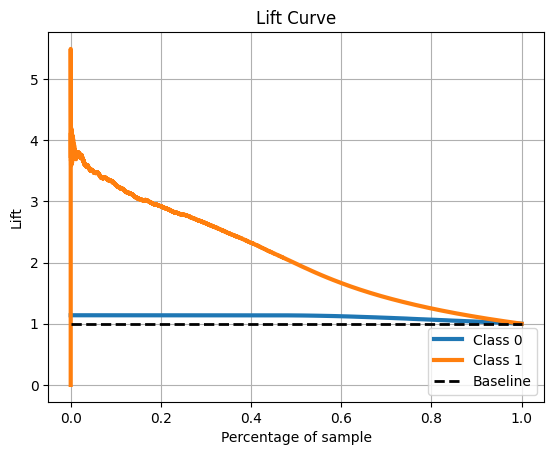

In [142]:
# Tuned Parameters
best_param = {
'n_estimators': 1800, 
'learning_rate': 0.025, 
'num_leaves': 60, 
'max_depth': 9, 
'min_split_gain': 0.1, 
'min_child_samples': 85, 
'subsample': 0.90, 
'colsample_bytree': 0.7, 
'neg_bagging_fraction': 0.5}

# Final Model
model_lgbm = LGBMClassifier(**best_param,
                            random_state = 42).fit(X_train_ml, y_train_ml)
              
# Model Evaluation - Precision at K, Recall at K, Cumulative Gain Curve and Lift Curve
model_eval(model_lgbm, X_train_ml, y_train_ml, X_val, y_validation)

## 10. **Financial Results (Performance Metrics Interpretation)**

## 11. **Conclusion and Next Steps**

# **Model Deployment**